In [1]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,ElementQuad2,ElementQuad1,
    asm, bmat, condense, solve, BilinearForm, LinearForm, Mesh, Functional, MeshQuad
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse.linalg import eigsh, eigs, splu, LinearOperator


In [2]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True, colormap='viridis', cmap='viridis')
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')
    plt.tight_layout()
    plt.show()

    # Campo vectorial de velocidad (quiver)
    # Para P2, necesitamos solo los valores en los vértices (primeros n_nodes)
    n_vertices = mesh.p.shape[1]
    
    # Extraer solo los valores en los vértices
    u_x_vertices = u_x[:n_vertices]
    u_y_vertices = u_y[:n_vertices]
    u_mag_vertices = np.sqrt(u_x_vertices**2 + u_y_vertices**2)
    
    # Obtener coordenadas de los nodos
    coords = mesh.p
    x_coords = coords[0, :]
    y_coords = coords[1, :]
    
    
    # Create a new figure for the quiver plot
    fig_quiver, ax_quiver = plt.subplots(1, 1, figsize=(10, 8))
    
    # Quiver plot
    quiver = ax_quiver.quiver(x_coords, y_coords, 
                      u_x_vertices, u_y_vertices, u_mag_vertices,
                      cmap='jet', scale=20, alpha=1, width=0.005)
    
    # Plot domain boundaries
    nodes  = mesh.p
    facets = mesh.facets
    boundary_facets = mesh.boundary_facets()

    # Plot all boundary facets
    for i, e in enumerate(boundary_facets):
        facets_e = facets[:, e]
        nodosx = nodes[0, facets_e]
        nodosy = nodes[1, facets_e]
        ax_quiver.plot(nodosx, nodosy, 'k-', linewidth=1.5, alpha=0.8)
    
    
    ax_quiver.set_title(r'Campo de velocidad $\mathbf{u}$')
    ax_quiver.set_aspect('equal')
    ax_quiver.set_xlabel('x')
    ax_quiver.set_ylabel('y')
    
    # Add colorbar
    cbar = plt.colorbar(quiver, ax=ax_quiver)
    cbar.set_label('Magnitud de velocidad')

    plt.tight_layout()
    plt.show()

In [95]:
# Definir dominio y mallado
nx, ny = 64, 64
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

In [96]:
# Asignar ID a las fronteras
mesh = mesh.with_boundaries({
    'wall':   lambda x: x[0] == 0.0,
    'inflow': lambda x: (x[0] == 1.0) | (x[1] == 0.0),
    'outflow': lambda x: x[1] == 1.0,
})


## Stokes

In [97]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

In [98]:
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    advection_field = w['w']
    grad_u = grad(u)

    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   

In [99]:
mu = 1
Re = 1
def u_func_x(x, y):
    return (np.cos(np.pi * x) -1 )/ np.pi + 0*y
def u_func_y(x, y):
    return np.sin(np.pi * x)*y
def p_exact(x, y):
    return np.sin(np.pi * x) + 0*y

def f_exact_x_stokes(x,y):
    return 2*np.pi*np.cos(np.pi*x)

def f_exact_y_stokes(x,y):
    return (np.pi**2) * np.sin(np.pi*x)*y

# def f_exact_x_ns(x,y):
#     return 2*np.pi*np.cos(np.pi*x) -(1/np.pi) * np.sin(np.pi*x)*(np.cos(np.pi*x)-1)

# def f_exact_y_ns(x,y):
#     return np.pi**2 * np.sin(np.pi*x) * y + (np.cos(np.pi*x) - 1) * np.cos(np.pi*x) * y + (np.sin(np.pi*x)**2) * y




In [100]:
x_boundary = np.zeros(Nu + Np)

# Fronteras de la velocidad

# Obtener DOFs de las fronteras de la base de velocidad
dofs_wall     = basis_u.get_dofs('wall').all()
dofs_inflow   = basis_u.get_dofs('inflow').all()
dofs_outflow  = basis_u.get_dofs('outflow').all()
dofs_p_outflow = basis_p.get_dofs('outflow').all()
# Elementos con condiciones de Dirichlet para la velocidad
# Impares y, pares x
y_wall    = basis_u.doflocs[1, dofs_wall[1::2]] 
y_inflow  = basis_u.doflocs[1, dofs_inflow[1::2]]
y_outflow = basis_u.doflocs[1, dofs_outflow[1::2]]

x_wall   = basis_u.doflocs[0, dofs_wall[::2]]  
x_inflow = basis_u.doflocs[0, dofs_inflow[::2]]
x_outflow    = basis_u.doflocs[0, dofs_outflow[::2]]

x_boundary[dofs_wall[::2]]    =  u_func_x(x_wall, y_wall)
x_boundary[dofs_wall[1::2]]   =  u_func_y(x_wall, y_wall)

x_boundary[dofs_inflow[::2]]   =  u_func_x(x_inflow, y_inflow)
x_boundary[dofs_inflow[1::2]]  =  u_func_y(x_inflow, y_inflow)

# x_boundary[dofs_outflow[::2]]     =  u_func_x(x_outflow, y_outflow)  # componente x
# x_boundary[dofs_outflow[1::2]]    =  u_func_y(x_outflow, y_outflow)  # componente y


dofs_u_boundary = np.concatenate([
    dofs_wall,
    dofs_inflow,
    # dofs_outflow
])

x_boundary[Nu + 0]  = p_exact(0.0, 0.0)
dofs_p_boundary = np.array([Nu+0])# + np.concatenate([np.array([0])])

D_all = np.unique(np.concatenate([dofs_u_boundary, dofs_p_boundary]))

In [101]:
@LinearForm
def rhs_u(v, w):
    x, y = w.x
    fx = f_exact_x_stokes(x, y)
    fy = f_exact_y_stokes(x, y)
    return fx * v[0] + fy * v[1]

b_u = asm(rhs_u, basis_u) 
b_p = np.zeros(Np)  
F   = np.concatenate([b_u, b_p])

In [102]:
mu = 1.0

# Calcular solución inicial de stokes
K_stokes = bmat([[mu * A,     B.T],  
                 [B,         None]], format='csr')

sol0 = solve(*condense(K_stokes, F, D=D_all, x=x_boundary))
u_ref = sol0[:Nu].copy()
p_ref = sol0[Nu:Nu+Np].copy()

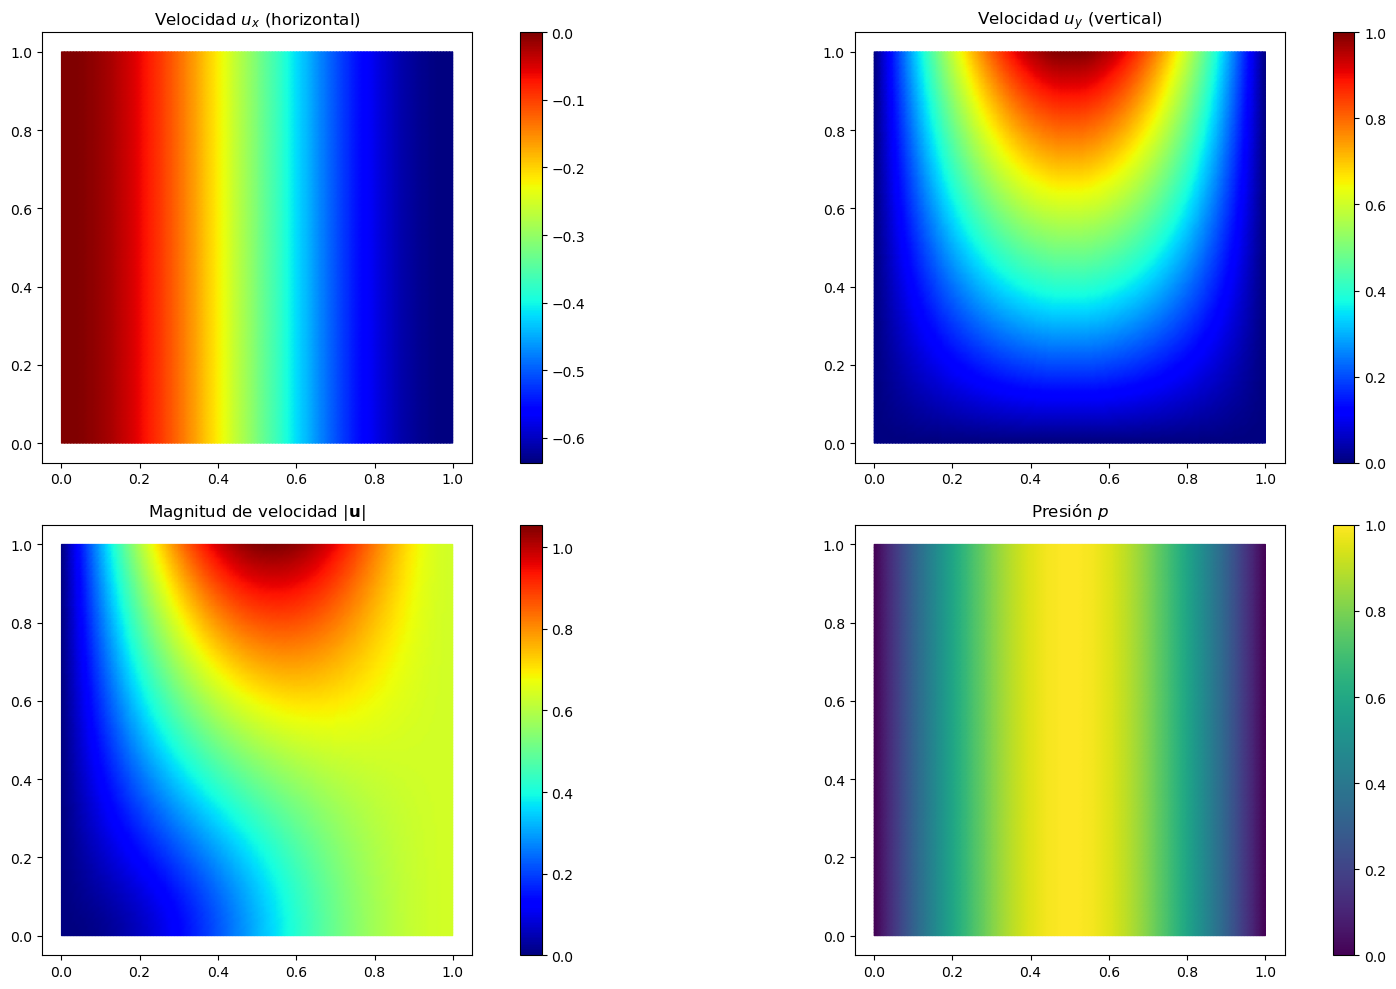

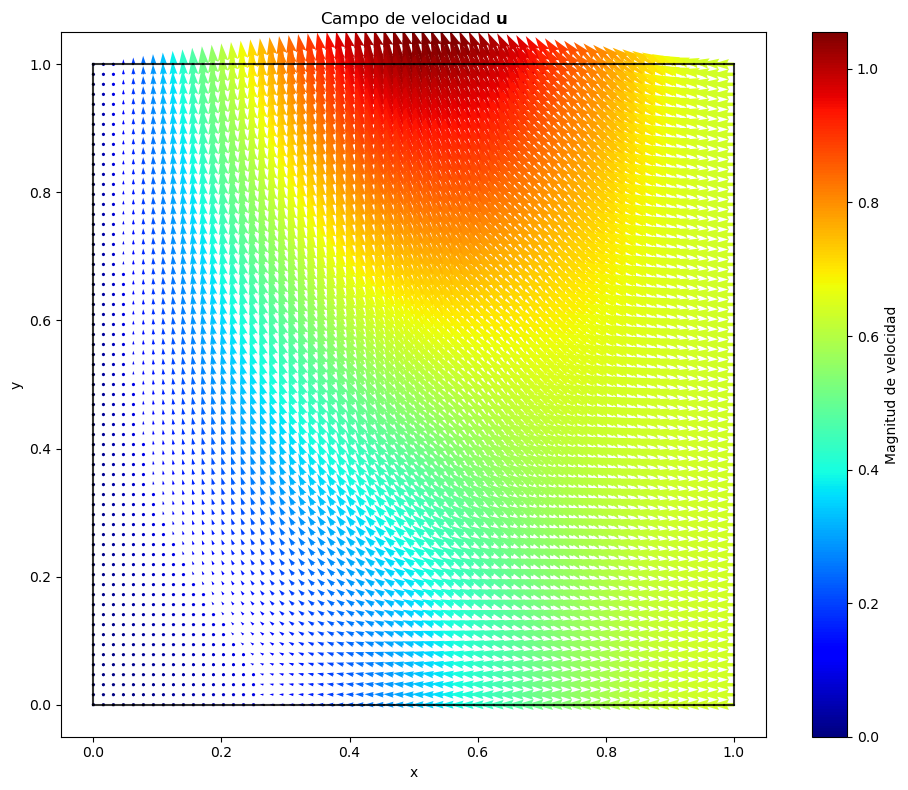

In [103]:
graficar_stokes(u_ref, p_ref, mesh, basis_p, basis_u)

In [104]:
fbasis_u = basis_u.boundary('outflow', intorder=4)
fbasis_p = basis_p.boundary('outflow', intorder=4)

@BilinearForm
def form_grad_v_n_v(u, v, w):
    # u es la funcion trial que recorre por columna, v la de test que recorre por fila
    gradv = grad(u) # shape (comp ux o uy, dim x o y, elem, q)
    n     = w.n     # shape (dim x o y, elem, q)
                    # v shape (dim x o y, elem, q)
    grad_v_n = np.einsum('cdeq,deq->ceq', gradv, n)
    return np.einsum('ceq,ceq->eq', grad_v_n, v)

@BilinearForm
def form_q_n_v(q, v, w):
    # shape v (dim x o y, elem, q)
    # shape q (elem, q)
    # shape w.n (dim x o y, elem, q)
    # print(f'shape v: {v.shape}, shape q: {q.shape}, shape w.n: {w.n.shape}')
    vn = np.einsum('ceq,ceq->eq', v, w.n)
    return q * vn

# Ensamblar matrices
M_u = asm(form_grad_v_n_v, fbasis_u, fbasis_u)  # (Nu x Nu)
M_p = asm(form_q_n_v, fbasis_p, fbasis_u)       # (Nu x Np)


In [105]:
np.sum(M_u@u_ref - M_p@p_ref)

np.float64(5.6961475466666106e-05)

### Integral de linea en outflow

In [138]:
def precompute_outflow_operators(basis_u, basis_p):

    # Crear FacetBasis para el outflow
    fbasis_u = basis_u.boundary('outflow', intorder=4)
    fbasis_p = basis_p.boundary('outflow', intorder=4)

    # Extraer información de los facets
    normals  = np.array(fbasis_u.normals)    # (2, n_facets, n_qp)
    weights  = np.array(fbasis_u.dx)         # (n_facets, n_qp)
    n_facets = weights.shape[0]
    n_qp     = weights.shape[1]

    # DOFs locales por facets
    edofs_u = np.array(fbasis_u.element_dofs)  # (n_dofs_local_u, n_facets)
    edofs_p = np.array(fbasis_p.element_dofs)  # (n_dofs_local_p, n_facets)

    n_dofs_local_u = edofs_u.shape[0]
    n_dofs_local_p = edofs_p.shape[0]
    Nu_total       = basis_u.N
    Np_total       = basis_p.N

    # Para velocidad: grad_phi_u_full[dim, comp, dof_local, n_facets, n_qp]
    grad_phi_u_full = np.zeros((2, 2, n_dofs_local_u, n_facets, n_qp))

    for f in range(n_facets):
        for d in range(n_dofs_local_u):
            e_vec = np.zeros(Nu_total)
            e_vec[edofs_u[d, f]] = 1.0 # Se reemplaza por 1 en el DOF global
            
            # Interpolar
            interp = fbasis_u.interpolate(e_vec) # Interpolar en los nqp de la faceta f
            # Solo extraer el gradiente para esta faceta
            grad_phi_u_full[:, :, d, f, :] = np.array(interp.grad)[:, :, f, :]

    # Para presión: phi_p_full[dof_local, n_facets, n_qp]
    phi_p_full = np.zeros((n_dofs_local_p, n_facets, n_qp))

    for f in range(n_facets):
        for d in range(n_dofs_local_p):
            e_vec = np.zeros(Np_total)
            e_vec[edofs_p[d, f]] = 1.0
            
            interp = fbasis_p.interpolate(e_vec)
            phi_p_full[d, f, :] = np.array(interp)[f, :]
    
    dict_return = {
        'normals': normals,
        'weights': weights,
        'edofs_u': edofs_u,
        'grad_phi_u_full': grad_phi_u_full,
        'edofs_p': edofs_p,
        'phi_p_full': phi_p_full}
    return dict_return
    

In [24]:
operators_outflow = precompute_outflow_operators(basis_u, basis_p)

u_local = u_ref[operators_outflow['edofs_u']]
p_local = p_ref[operators_outflow['edofs_p']]

# Compute physical values at the boundary
grad_u = np.einsum('df, icdfq -> icfq', u_local, operators_outflow['grad_phi_u_full'])
p_val  = np.einsum('df, dfq -> fq', p_local, operators_outflow['phi_p_full'])

# Compute integral
grad_u_dot_n = np.einsum('icfq, ifq -> cfq', grad_u, operators_outflow['normals'])
integrando   = grad_u_dot_n - p_val[np.newaxis, :, :] * operators_outflow['normals']
 
sum_integrando = integrando[0] * operators_outflow['weights']  + integrando[1] * operators_outflow['weights']

integral_x = np.sum(integrando[0] * operators_outflow['weights'])
integral_y = np.sum(integrando[1] * operators_outflow['weights'])


print("Condicion de frontera outflow:", integral_x + integral_y)

NameError: name 'precompute_outflow_operators' is not defined

In [49]:
basis_u.boundary('outflow', intorder=6).dofs.N

np.int32(50)

In [25]:
# Componente X
@LinearForm
def outflow_u_x(v, w):
    return dot(grad(v), w.n)[0]

@LinearForm
def outflow_p_x(v, w):
    # v es la base de presión.
    return -1.0 * v * w.n[0]

# Componente Y
@LinearForm
def outflow_u_y(v, w):
    return dot(grad(v), w.n)[1]

@LinearForm
def outflow_p_y(v, w):
    return -1.0 * v * w.n[1]

fbasis_u = basis_u.boundary('outflow', intorder=6)
fbasis_p = basis_p.boundary('outflow', intorder=6)

C_ux = asm(outflow_u_x, fbasis_u)
C_uy = asm(outflow_u_y, fbasis_u)

C_px = asm(outflow_p_x, fbasis_p)
C_py = asm(outflow_p_y, fbasis_p)

integral_x = C_ux @ u_ref + C_px @ p_ref
integral_y = C_uy @ u_ref + C_py @ p_ref

print("Condicion de frontera outflow:", integral_x + integral_y)


Condicion de frontera outflow: 0.02429881260578377


In [38]:
fbasis_u = basis_u.boundary('outflow', intorder=4)
u_b      = fbasis_u.interpolate(u_ref) 
fbasis_p = basis_p.boundary('outflow', intorder=4)
p_b      = fbasis_p.interpolate(p_ref)

@Functional
def traction_u_normal(w):
    u  = w['u']
    gu = u.grad   
    t  = dot(gu, w.n)
    return t

@Functional
def traction_p_normal(w):
    p = w['p']
    return -p

T_u = traction_u_normal.assemble(fbasis_u, u=u_b)

T_p = traction_p_normal.assemble(fbasis_p, p=p_b)

# T_total = T_u + T_p
print("Condicion de frontera outflow:", T_total)



Condicion de frontera outflow: 0.024298812605783704


In [76]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)


In [77]:
dofs_outflow_x = dofs_outflow[::2]
dofs_outflow_y = dofs_outflow[1::2]

ux_outflow = u_ref[dofs_outflow_x]
uy_outflow = u_ref[dofs_outflow_y]
p_outflow = p_ref[dofs_p_outflow]


In [72]:
dofs_outflow_x

array([ 4, 10, 16, 30, 44], dtype=int32)

In [73]:
grad_phix.shape

(6, 2, 6, 8)

In [75]:
dofs_outflow_x

array([ 4, 10, 16, 30, 44], dtype=int32)

In [74]:
grad_phix[dofs_outflow_x,0,:,:]

IndexError: index 10 is out of bounds for axis 0 with size 6

(6, 6)

### Error

Residuo momentum en X - min: 2.7966e-05, max: 1.2980e-01
Residuo momentum en Y - min: 1.1641e-06, max: 2.4198e-01
Residuo continuidad - min: 2.1679e-07, max: 2.9179e-04


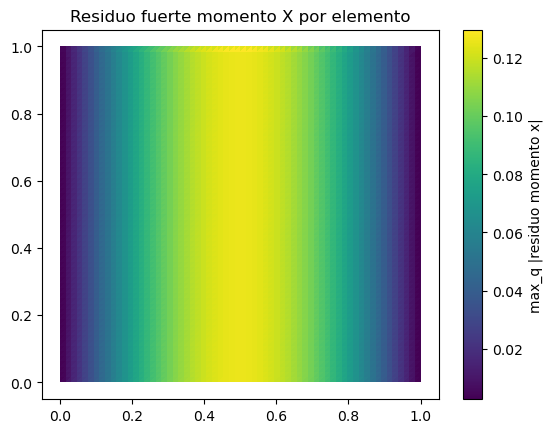

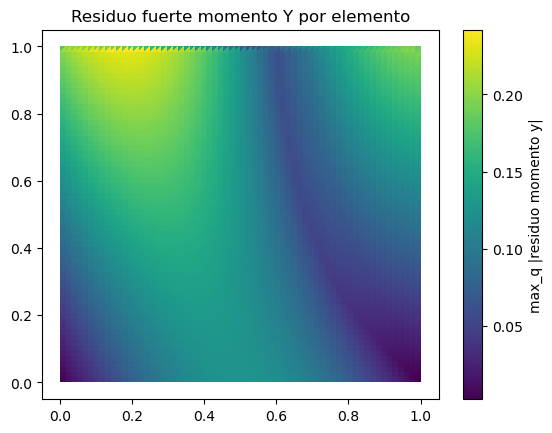

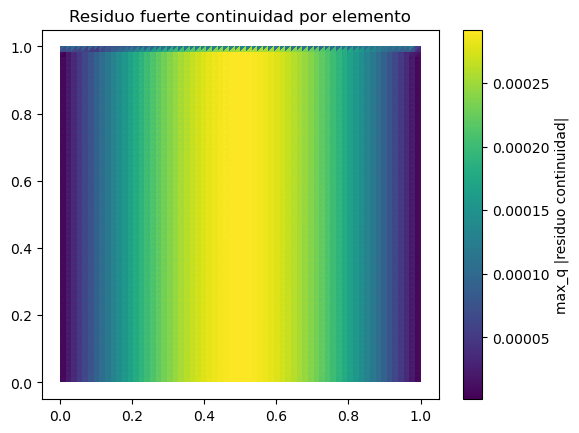

In [175]:
### Error forma fuerte
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_ref[0::2]
u_y = u_ref[1::2] 
p_sol = p_ref 

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p)
# Velocidad y presión en puntos de cuadratura
u_val = np.einsum('dq, de -> qe', phix, u_x[edofs_x]) 
v_val = np.einsum('dq, de -> qe', phiy, u_y[edofs_y])
p_val = np.einsum('dq, de -> qe', phip, p_sol[edofs_p])

# Calcular operadores en coordenadas físicas
grad_u_fisico_x = np.einsum('de, diqe -> iqe', u_x[edofs_x], grad_phix)
grad_u_fisico_y = np.einsum('de, diqe -> iqe', u_y[edofs_y], grad_phiy)
grad_p_fisico   = np.einsum('de, diqe -> iqe', p_sol[edofs_p], grad_phip)
laplacian_u_x   = np.einsum('de, de -> e', u_x[edofs_x], laplacian_phix)
laplacian_u_y   = np.einsum('de, de -> e', u_y[edofs_y], laplacian_phiy)

du_dx = grad_u_fisico_x[0]
du_dy = grad_u_fisico_x[1]
dv_dx = grad_u_fisico_y[0]
dv_dy = grad_u_fisico_y[1]
dp_dx = grad_p_fisico[0]
dp_dy = grad_p_fisico[1]

# Coordenadas de los puntos de cuadratura reales
coords = basis_x.global_coordinates()
X_quad = coords[0]
Y_quad = coords[1]

val_f_x = f_exact_x_stokes(X_quad, Y_quad) 
val_f_y = f_exact_y_stokes(X_quad, Y_quad) 

# Residuo momentum en X: dp/dx - nu*Lap(u)

res_momentum_x = np.abs(dp_dx - (laplacian_u_x/mu) - val_f_x.T)

# Residuo momentum en Y: dp/dy - nu*Lap(v)
res_momentum_y = np.abs(dp_dy - (laplacian_u_y/mu) - val_f_y.T)

# Residuo Continuidad: du/dx + dv/dy
res_continuity = np.abs(du_dx + dv_dy)

print(f"Residuo momentum en X - min: {np.min(res_momentum_x):.4e}, max: {np.max(res_momentum_x):.4e}")
print(f"Residuo momentum en Y - min: {np.min(res_momentum_y):.4e}, max: {np.max(res_momentum_y):.4e}")
print(f"Residuo continuidad - min: {np.min(res_continuity):.4e}, max: {np.max(res_continuity):.4e}")
# Maximo por elemento
resx_elem = res_momentum_x.max(axis=0)   # (n_elem,)
resy_elem = res_momentum_y.max(axis=0)
resc_elem = res_continuity.max(axis=0)

# Geometria de la malla
p = basis_x.mesh.p.T   # nodos: shape (n_nodes, 2)
t = basis_x.mesh.t.T   # elementos (triangulos): shape (n_elem, nvert)

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resx_elem, shading="flat")
plt.colorbar(label="max_q |residuo momento x|")
plt.title("Residuo fuerte momento X por elemento")

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resy_elem, shading="flat")
plt.colorbar(label="max_q |residuo momento y|")
plt.title("Residuo fuerte momento Y por elemento")

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resc_elem, shading="flat")
plt.colorbar(label="max_q |residuo continuidad|")
plt.title("Residuo fuerte continuidad por elemento")

plt.show()


## Navier Stokes

In [211]:
def f_exact_x_ns(x,y):
    return 2*np.pi*np.cos(np.pi*x) -(1/np.pi) * np.sin(np.pi*x)*(np.cos(np.pi*x)-1)

def f_exact_y_ns(x,y):
    return np.pi**2 * np.sin(np.pi*x) * y + (np.cos(np.pi*x) - 1) * np.cos(np.pi*x) * y + (np.sin(np.pi*x)**2) * y

In [212]:
@LinearForm
def rhs_u(v, w):
    x, y = w.x
    fx = f_exact_x_ns(x, y)
    fy = f_exact_y_ns(x, y)
    return fx * v[0] + fy * v[1]

b_u = asm(rhs_u, basis_u) 
b_p = np.zeros(Np)  
F   = np.concatenate([b_u, b_p])

In [213]:
def solve_ns_picard(u_init, p_init, Re, max_iter, tol):
    u = u_init
    p = p_init
    for it in range(max_iter):
        # Campo de advección congelado w := u^(it) en puntos de cuadratura
        W = basis_u.interpolate(u)   

        # Ensambla bloque convectivo C(w)
        C = asm(convection, basis_u, w=W)

        # Matriz bloque del paso linealizado
        K = bmat([[(1/Re) * A + C, B.T ],
                  [B,              None]], format='csr')

        # Resolver
        sol = solve(*condense(K, F, D=D_all, x=x_boundary))
        u_new = sol[:Nu]
        p_new = sol[Nu:Nu+Np]

        # Criterio de convergencia
        du = u_new - u
        rel_u = np.linalg.norm(du) / (np.linalg.norm(u_new) + 1e-16)

        dp = p_new - p
        rel_p = np.linalg.norm(dp) / (np.linalg.norm(p_new) + 1e-16)

        # # Sub-relajación si se desea
        u = u_new
        p = p_new

        if rel_u < tol and rel_p < tol:
            print(f"Convergió en {it+1} iteraciones, residuo {max(rel_u, rel_p):.4e}")
            return u, p, True
    print("No convergió en el número máximo de iteraciones")
    return u, p, False

In [216]:
# Resolver incrementanto Re
Re = 1
Re_linspace = np.linspace(1, Re, 1)

for R in Re_linspace:
    print(f"Resolviendo para Re = {R:.2f}")
    u_ref, p_ref, flag = solve_ns_picard(u_ref, p_ref, R, max_iter=500, tol=1e-12)

    if not flag:
        print(f"No se pudo converger para este Re = {R:.2f}.")
        break

u_sol = u_ref
p_sol = p_ref


Resolviendo para Re = 1.00
Convergió en 1 iteraciones, residuo 8.6442e-13


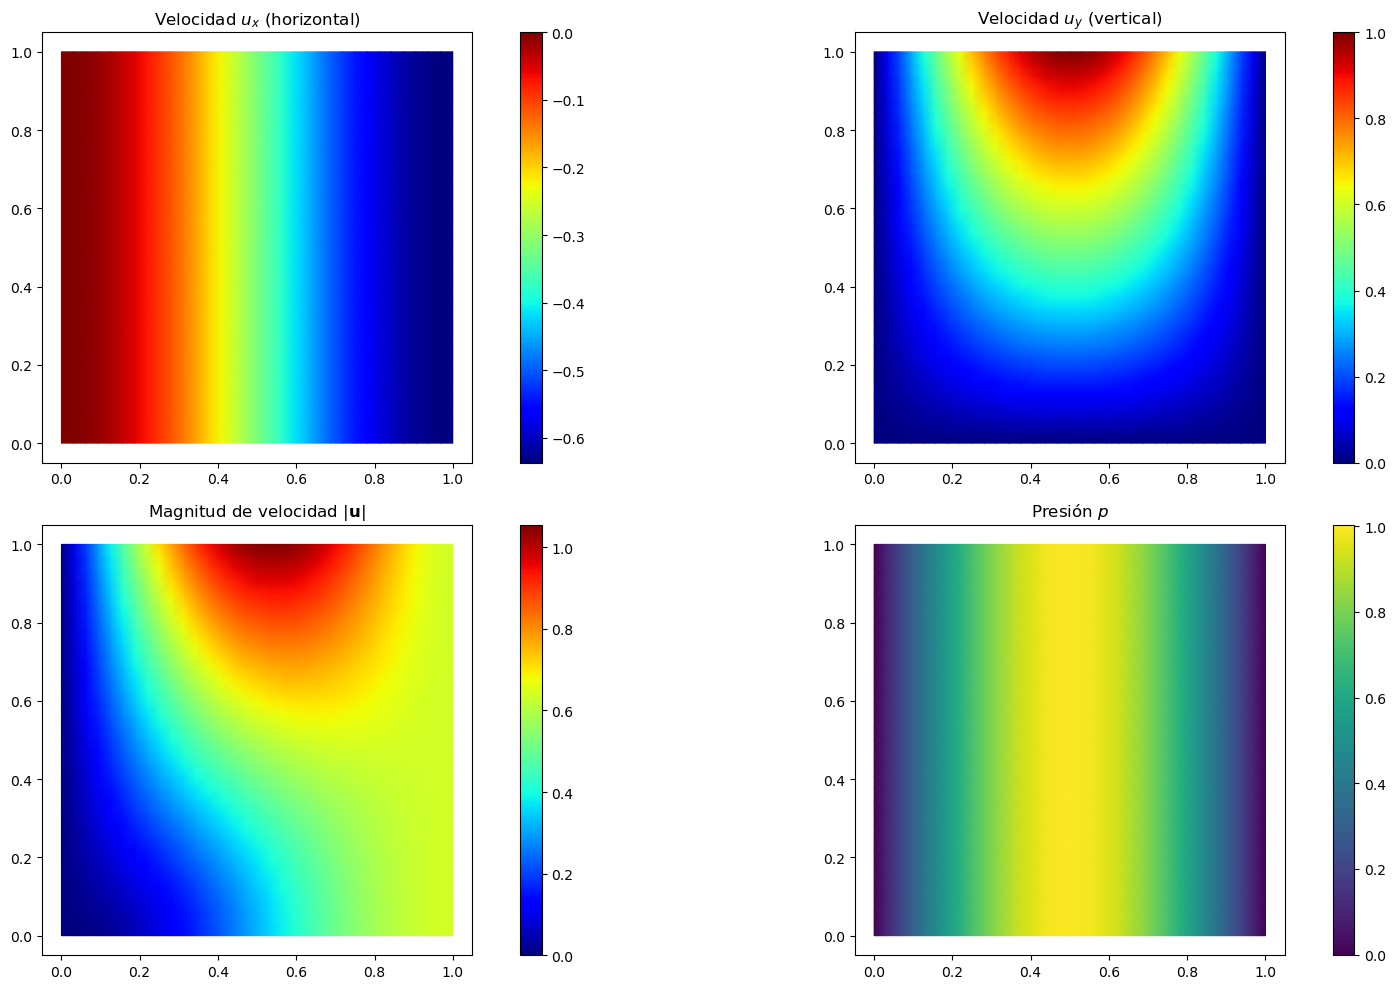

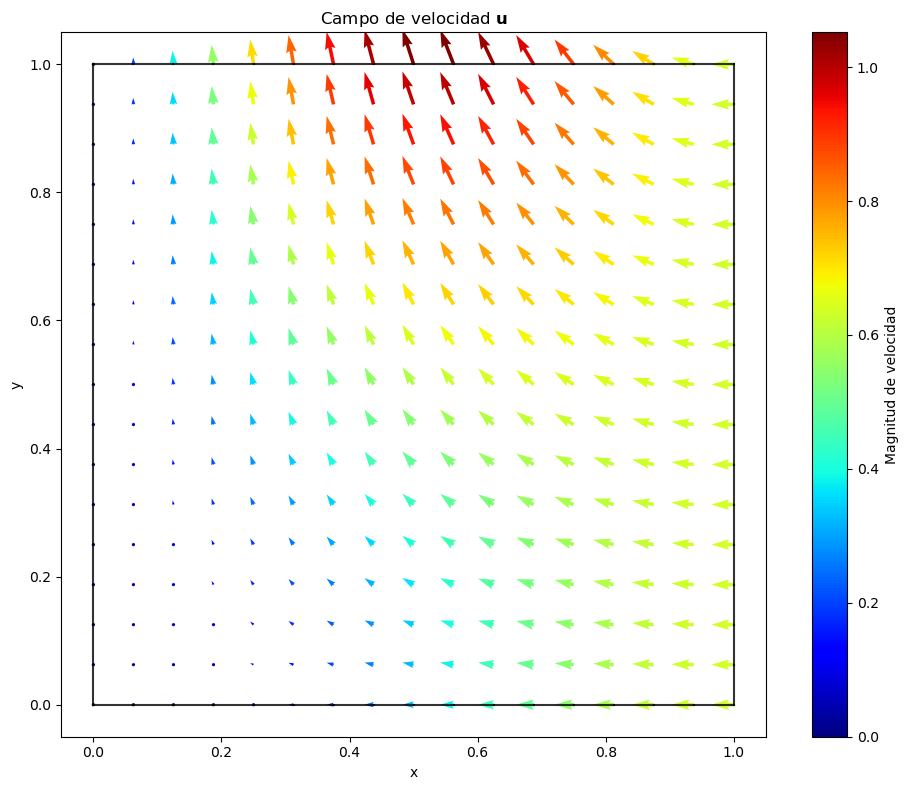

In [217]:
graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

In [218]:
operators_outflow = precompute_outflow_operators(basis_u, basis_p)

u_local = u_sol[operators_outflow['edofs_u']]
p_local = p_sol[operators_outflow['edofs_p']]

# Compute physical values at the boundary
grad_u = np.einsum('df, icdfq -> icfq', u_local, operators_outflow['grad_phi_u_full'])
p_val = np.einsum('df, dfq -> fq', p_local, operators_outflow['phi_p_full'])

# Compute integral
grad_u_dot_n = np.einsum('icfq, ifq -> cfq', grad_u, operators_outflow['normals'])
integrando   = grad_u_dot_n - p_val[np.newaxis, :, :] * operators_outflow['normals']

integral_x = np.sum(integrando[0] * operators_outflow['weights'])
integral_y = np.sum(integrando[1] * operators_outflow['weights'])

print("Integral outflow - componente x:", integral_x)
print("Integral outflow - componente y:", integral_y)

Integral outflow - componente x: 5.551115123125783e-17
Integral outflow - componente y: 0.0007775843322704878


### Error forma fuerte

In [187]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2] 
p_sol = p_sol 

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p)
# Velocidad y presión en puntos de cuadratura
u_val = np.einsum('dq, de -> qe', phix, u_x[edofs_x]) 
v_val = np.einsum('dq, de -> qe', phiy, u_y[edofs_y])
p_val = np.einsum('dq, de -> qe', phip, p_sol[edofs_p])

# Calcular operadores en coordenadas físicas
grad_u_fisico_x = np.einsum('de, diqe -> iqe', u_x[edofs_x], grad_phix)
grad_u_fisico_y = np.einsum('de, diqe -> iqe', u_y[edofs_y], grad_phiy)
grad_p_fisico   = np.einsum('de, diqe -> iqe', p_sol[edofs_p], grad_phip)
laplacian_u_x   = np.einsum('de, de -> e', u_x[edofs_x], laplacian_phix)
laplacian_u_y   = np.einsum('de, de -> e', u_y[edofs_y], laplacian_phiy)

du_dx = grad_u_fisico_x[0]
du_dy = grad_u_fisico_x[1]
dv_dx = grad_u_fisico_y[0]
dv_dy = grad_u_fisico_y[1]
dp_dx = grad_p_fisico[0]
dp_dy = grad_p_fisico[1]

# Coordenadas de los puntos de cuadratura reales
coords = basis_x.global_coordinates()
X_quad = coords[0]
Y_quad = coords[1]

val_f_x = f_exact_x_ns(X_quad, Y_quad) 
val_f_y = f_exact_y_ns(X_quad, Y_quad) 

# Residuo momentum en X: dp/dx - nu*Lap(u)

res_momentum_x = np.abs((u_val * du_dx + v_val * du_dy) + dp_dx - (laplacian_u_x/Re) - val_f_x.T)

# Residuo momentum en Y: dp/dy - nu*Lap(v)
res_momentum_y = np.abs((u_val * dv_dx + v_val * dv_dy) + dp_dy - (laplacian_u_y/Re) - val_f_y.T)

# Residuo Continuidad: du/dx + dv/dy
res_continuity = np.abs(du_dx + dv_dy)

print(f"Residuo momentum en X - min: {np.min(res_momentum_x):.4e}, max: {np.max(res_momentum_x):.4e}")
print(f"Residuo momentum en Y - min: {np.min(res_momentum_y):.4e}, max: {np.max(res_momentum_y):.4e}")
print(f"Residuo continuidad - min: {np.min(res_continuity):.4e}, max: {np.max(res_continuity):.4e}")

Residuo momentum en X - min: 1.5385e-06, max: 1.3907e+02
Residuo momentum en Y - min: 3.3721e-06, max: 1.4015e+02
Residuo continuidad - min: 2.1269e-09, max: 4.0704e-01


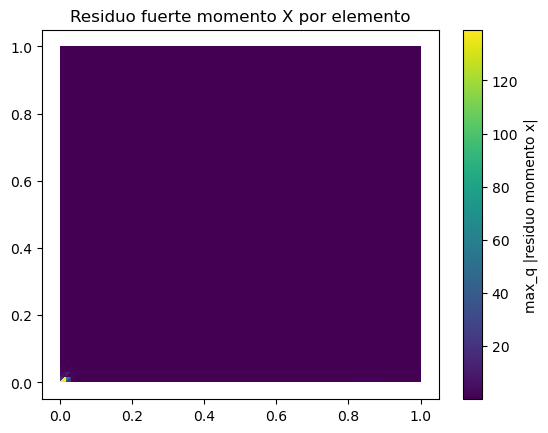

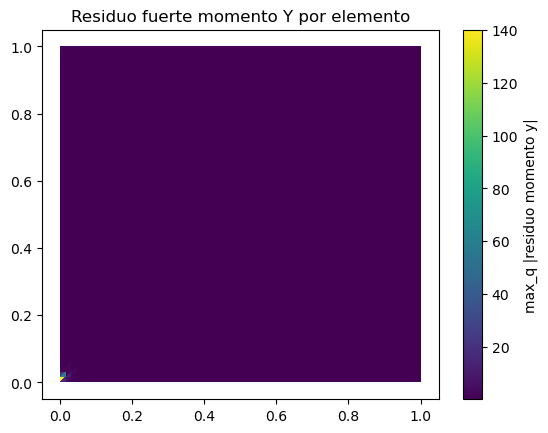

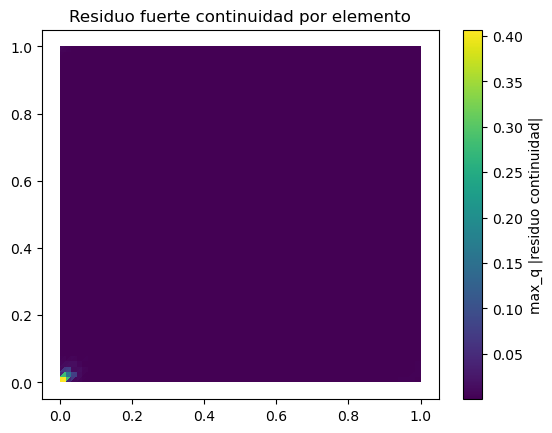

In [188]:
# Maximo por elemento
resx_elem = res_momentum_x.max(axis=0)   # (n_elem,)
resy_elem = res_momentum_y.max(axis=0)
resc_elem = res_continuity.max(axis=0)

# Geometria de la malla
p = basis_x.mesh.p.T   # nodos: shape (n_nodes, 2)
t = basis_x.mesh.t.T   # elementos (triangulos): shape (n_elem, nvert)

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resx_elem, shading="flat")
plt.colorbar(label="max_q |residuo momento x|")
plt.title("Residuo fuerte momento X por elemento")

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resy_elem, shading="flat")
plt.colorbar(label="max_q |residuo momento y|")
plt.title("Residuo fuerte momento Y por elemento")

plt.figure()
plt.tripcolor(p[:, 0], p[:, 1], t, facecolors=resc_elem, shading="flat")
plt.colorbar(label="max_q |residuo continuidad|")
plt.title("Residuo fuerte continuidad por elemento")

plt.show()


### Eigenfunctions

In [57]:
import sys
import numpy as np
from skfem import (
    Basis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, BilinearForm, LinearForm, Mesh, MeshTri
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import dot
import pandas as pd
import scipy.sparse as sp
from scipy.sparse.linalg import eigs

P_boundary_option = 1 # 1: presión media cero, 2: presión en un punto

# Importar malla
# Definir dominio y mallado
nx, ny = 32, 32
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)
# Asignar ID a las fronteras
mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})


# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N      = Nu + Np

# Ensamblaje de matrices
@BilinearForm
def mass_matrix(u, v, w):
    return dot(u, v)

nu = 1.0

A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)   
M =  asm(mass_matrix, basis_u)  


if P_boundary_option == 1:
    print('Condición: presión media cero')
    @LinearForm
    def mean_vec(q, w):
        return q

    m    = asm(mean_vec, basis_p)    # shape: (Np,)
    Mcol = m.reshape((-1, 1))     # (Np,1)
    Mrow = m.reshape((1,  -1))    # (1,Np)

 
    # Construcción del ssitema
    K = bmat([[nu*A,    B.T, None],
            [B,    None, Mcol],
            [None, Mrow, np.array([1])]], format='csr') 

    zeros = sp.csr_matrix((basis_p.N, basis_p.N))  
    L = bmat([[M,   None, None],
            [None, zeros, Mcol*0],
            [None, Mrow*0, None]], format='csr')

    # Condiciones de frontera
    D_all = np.unique(basis_u.get_dofs().all())

elif P_boundary_option == 2:
    print('Condición: presión en un punto')

    # Construcción del ssitema
    K = bmat([[nu*A,    B.T],
              [B   ,    None]], format='csr') 
    
    zeros = sp.csr_matrix((basis_p.N, basis_p.N))  
    L = bmat([[M,    None],
              [None, zeros]], format='csr')
    
    # Condiciones de frontera
    D_all = np.unique(basis_u.get_dofs().all())

# Remover DOFs
A_sys, xI, I   = condense(K, D=D_all)
M_sys, xIM, IM = condense(L, D=D_all)

# Resolver problema de valores propios generalizado
vals, vecs = eigs(A_sys, k=40, M=M_sys, sigma=0.0, which='LM', OPpart='r')

# Filtrar valores propios reales (parte imaginaria exactamente cero)
mask_real = np.isclose(vals.imag, 0)
vals = vals[mask_real].real
vecs = vecs[:, mask_real].real

# Ordenar autovalores
idx          = np.argsort(vals)
eigenvalues  = vals[idx]
eigenvectors = vecs[:, idx]

# Exportar todas las funciones propias y valores propios a CSV

# Crear arrays para todas las soluciones
n_modes        = len(eigenvalues)
all_u_velocity = np.zeros((Nu, n_modes))
all_p_pressure = np.zeros((Np, n_modes))

for sol_idx in range(n_modes):
    # Insertar la solución reducida en el vector global (con ceros en frontera)
    u_sol = np.zeros(K.shape[0])
    u_sol[I] = eigenvectors[:, sol_idx]
    
    # Separar componentes de velocidad y presión
    all_u_velocity[:, sol_idx] = u_sol[:Nu]
    all_p_pressure[:, sol_idx] = u_sol[Nu:Nu+Np]

# Exportar a CSV
# pd.DataFrame(all_u_velocity).to_csv('Data/velocity_eigenfunctions_stokes_sincos.csv', index=False)
# pd.DataFrame(all_p_pressure).to_csv('Data/pressure_eigenfunctions_stokes_sincos.csv', index=False)
# pd.DataFrame({'eigenvalue': eigenvalues}).to_csv('Data/eigenvalues_stokes_sincos.csv', index=False)

print('Done!')

Condición: presión media cero
Done!


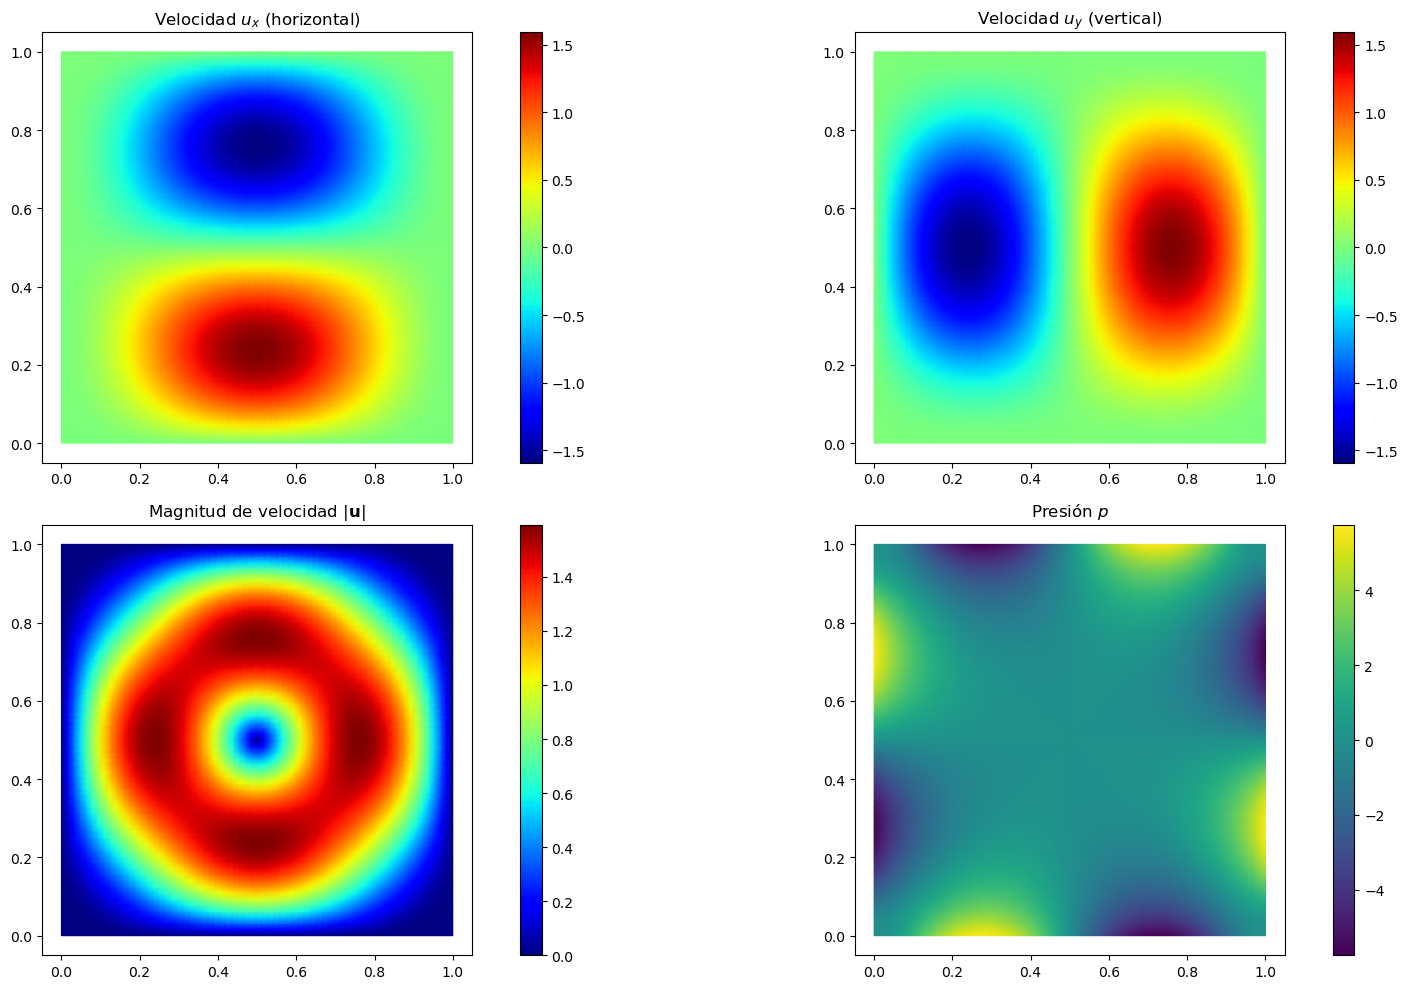

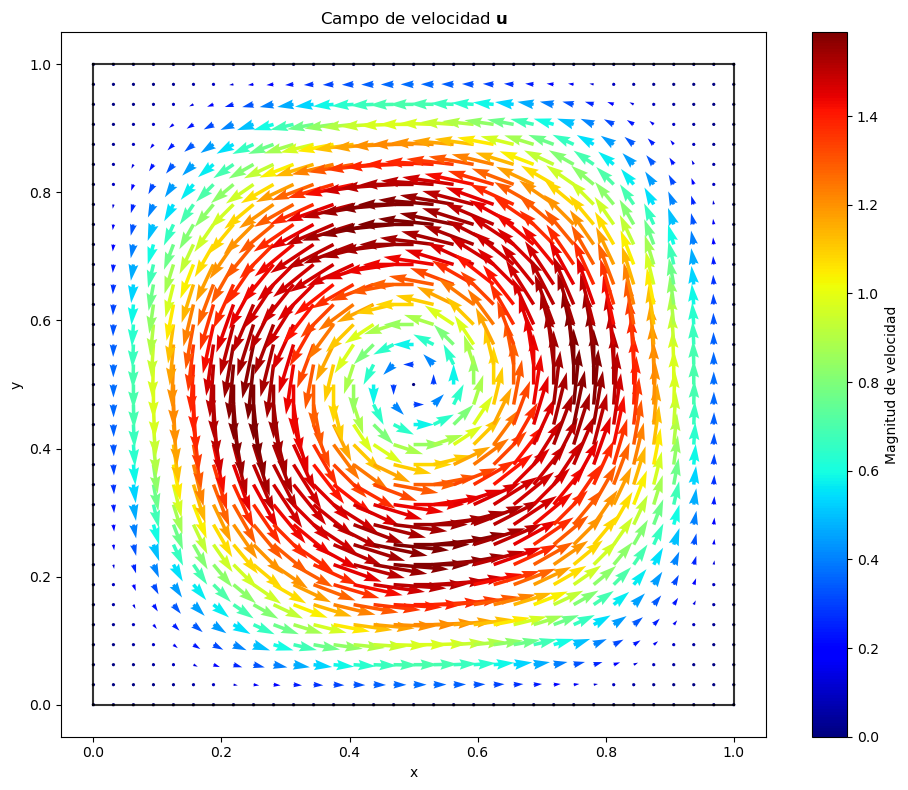

In [58]:
graficar_stokes(all_u_velocity[:,0], all_p_pressure[:,0], mesh, basis_p, basis_u)